# Playing with data: bike sharing

## 1. Bike sharing systems

Bike sharing has rapidly become a popular means of public transport in modern cities. Its benefits are numerous, including improved health and fitness for the users, decreased congestion on the road networks of the cities, and decreased environmental and pollutive impact from the more conventional means of public transport which rely on fossil fuels. Cycling is also widely considered to be fun! :)

In an effort to meet these needs and promote these benefits many companies have sprung up that offer a systematised bike-sharing service. All have a fleet of bicycles available for the customers, but deployal comes in two forms: from fixed stations with locking docking points, or on a "pick-up-drop-off" principle, where the user parks the bike in any accessible location for the next user to find it. Whilst the flexibility of the latter offers many benefits, we will focus on the former for our following experiments. We will use the [Capital Bike Sharing data](https://s3.amazonaws.com/capitalbikeshare-data/index.html) based around metropolitan District Columbia, USA, which are freely available from Capital's website.

The biggest problem for users of bike-sharing systems such as Capital's is being able to find a bike and/or a docking station when you need one. For example during the morning rush-hour, commuters to work might find that earlier users have already snapped up all the bikes. After eventually locating a bike and cycling to work, they might find that all the docking stations near their work are already full up from the earlier commuters. This can make usage of the system quite tricky and annoying! And of course the same problems apply to the evening homeward commute...

We will try to find patterns in usage, by applying techniques from machine learning (ML). Moreover we will attempt to predict demands (of bikes/spaces) at the stations, which a company could use to artificially reposition the bikes so as to better meet the users' requirements.

## 2. The data

The data available from Capital comprise a fairly large set (there are now roughly 3 x 10^6 bike journeys every year using their system), so there is some re-engineering required to make the ML techniques more tractable.

### 2.1 Importing

We assume the full data of years 2013--2017 (inclusive) have been downloaded from Capital's webpage and saved in the same folder as the notebook. We import them into pandas data-sets.

The data are split into yearly quarters. There are 5 years' data available, and 4 quarters per year, meaning we have 20 csv files to read. This is best accomplished with a for-loop, and saving the data in a dictionary.

In [3]:
# We start by setting up our Python workbook. We'll use pandas for manipulating our data; it relies on numpy, which is inherently
# important itself for maths in Python. For plotting purposes we'll use Python's built-in library matplotlib.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Now we import our data. This will likely take a few minutes.
num_years = 5
start = 3
datafolder = "C:/Users/sneak/Documents/Python Scripts/Bike_sharing/"
all_data = {}
for n in range(num_years):
    for m in range(4):
        all_data["Y201{0}".format(str(int(n+start))+"Q"+str(int(m+1)))] = \
        pd.read_csv(datafolder+r"201"+str(int(n+start))+"Q"+str(int(m+1))+"-capitalbikeshare-tripdata.csv")

In [4]:
# Having imported the data as separate dataframes, we will now combine them into a single dataframe. Later, for testing purposes,
# we'll import what data are available from 2018 (as of today, 2018/11/12, the year is not yet over), and see how our predictions
# compare.

all_data = pd.concat(all_data.values(),axis=0).reset_index(drop=True)

In [274]:
def capital_data_importer(datafolder,start_year,num_years):
    '''
    INPUTS:
        datafolder: the filepath for the data, as a string
        start_year: the initial year desired, in the format YYYY
        num_years: the number of years desired, as a non-negative integer
        
    RETURN:
        all_data: a pandas dataframe containing all the data
    '''
    # We initialise an empty dictionary.
    all_data = {}
    # Then we loop through the years...
    for n in range(num_years):
        # ...and through the quarters of each year.
        for m in range(4):
            # We assign a dictionary key of the form, e.g., 'Y2013Q2'.
            # Then we give it its value: a pandas dataframe from the imported csv data.
            all_data['Y{0}'.format(str(int(n+start_year))+'Q'+str(int(m+1)))] = \
            pd.read_csv(datafolder+str(int(n+start_year))+r'Q'+str(int(m+1))+'-capitalbikeshare-tripdata.csv')
    # Then we concatenate all the dataframes.
    all_data = pd.concat(all_data.values(),axis=0).reset_index(drop=True)
    return all_data

In [291]:
def stations_name_num_splitter (all_data, datafolder=None):
    '''
    INPUTS:
        all_data: a pandas dataframe containing the Capital bikesharing data
        datafolder: (optional) a path to a folder, as a string
    RETURN:
        a dictionary:
            'Station numbers' : a pandas dataframe with columns 'Start date', 'End date', 'Start stn', 'End stn'.
                Entries of 'Start/End date' are strings, entries of 'Start/End stn' are integers.
            'Station names' : a pandas dataframe with columns 'Start date', 'End date', 'Start station', 'End station'.
                Entries of 'Start/End date' are strings, entries of 'Start/End station' are strings (the stations' names)
            
    
    The function can also save station_names to csv in datafolder, so station_names can be deleted from the RAM if desired.
    WARNING: calling this function with datafolder != None will overwrite station_names.csv in datafolder!
    '''
    
    station_names = all_data[['Start date','End date','Start station','End station']]
    if datafolder != None:
        station_names.to_csv(datafolder+'station_names.csv',index=False)
    
    
    station_nums = all_data.drop(["Duration","Start station","End station","Bike number","Member type"],axis=1)
#     station_nums = all_data['Start date','End date','Start station number','End station number']]
    station_nums.rename(columns={'Start station number':'Start stn','End station number':'End stn'},inplace=True)
    station_nums['Start stn'] = station_nums['Start stn'].apply(int)
    station_nums['End stn'] = station_nums['End stn'].apply(int)
    # Now we find the minimum value:
    stn_min = np.min(station_nums["Start stn"])
    # Then we subtract it from all the station labels:
    station_nums["Start stn"] = station_nums["Start stn"] - stn_min
    station_nums["End stn"] = station_nums["End stn"] - stn_min
    
    return {'Station numbers' : station_nums, 'Station names' : station_names}

In [285]:
firstyear = capital_data_importer(datafolder,2013,1)

In [295]:
# stations_name_num_splitter(firstyear, datafolder)['Station names']

In [294]:
firstyear.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,688,2013-01-01 00:03:55,2013-01-01 00:15:24,31101,14th & V St NW,31106,Calvert & Biltmore St NW,W01210,Member
1,699,2013-01-01 00:04:39,2013-01-01 00:16:19,31236,37th & O St NW / Georgetown University,31304,36th & Calvert St NW / Glover Park,W01075,Member
2,365,2013-01-01 00:10:01,2013-01-01 00:16:06,31257,22nd & I St NW / Foggy Bottom,31239,Rhode Island & Connecticut Ave NW,w00527,Member
3,292,2013-01-01 00:12:55,2013-01-01 00:17:47,31614,11th & H St NE,31612,D St & Maryland Ave NE,W00040,Member
4,222,2013-01-01 00:13:24,2013-01-01 00:17:07,31239,Rhode Island & Connecticut Ave NW,31214,17th & Corcoran St NW,W20891,Member


In [298]:
def station_binner(station_nums,time_interval='H'):
    
    start_stns = pd.DataFrame(station_nums['Start stn'])
    start_stns.index=pd.DatetimeIndex(station_nums['Start date'])
    del start_stns.index.name
    
    end_stns = pd.DataFrame(station_nums['End stn'])
    end_stns.index=pd.DatetimeIndex(station_nums['End date'])
    del end_stns.index.name
    
    def resampled_vals_cntr(x):
        y = pd.Series(x)
        return y.value_counts().fillna(0)
    
    start_stns = start_stns.resample(time_interval)
    list_starts = start_stns['Start stn'].apply(list)
    starts_by_bin = list_starts.apply(lambda x: resampled_vals_cntr(x)).fillna(0).astype(int)
    
    end_stns = end_stns.resample(time_interval)
    list_ends = end_stns['End stn'].apply(list)
    ends_by_bin = list_ends.apply(lambda x: resampled_vals_cntr(x)).fillna(0).astype(int)
    
    demand_by_bin = starts_by_bin - ends_by_bin.iloc[:-1,:]
    
    return {'Starts by bin': starts_by_bin, 'Ends by bin' : ends_by_bin, 'Demand by bin' : demand_by_bin}

In [299]:
output = station_binner(all_data)

In [300]:
output['Starts by bin'].head()

,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 01:00:00,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 02:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Engineering

Let's get down to some data re-engineering. The most important features for our purposes are:
Start date, End date, Start station number and End station number.

The final two features (Bike number and Member type) might be interesting for some other analyses, but for predicting usage patterns don't hold much a-priori value. The Duration, Start and End stations can all be re-engineered from our key features.

After selecting and engineering our features we will then produce two new dataframes, indexed by Start and End dates, and resampled over some small sub-interval of time. We'll use 1-hour sub-intervals.

In [5]:
all_data.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,688,2013-01-01 00:03:55,2013-01-01 00:15:24,31101,14th & V St NW,31106,Calvert & Biltmore St NW,W01210,Member
1,699,2013-01-01 00:04:39,2013-01-01 00:16:19,31236,37th & O St NW / Georgetown University,31304,36th & Calvert St NW / Glover Park,W01075,Member
2,365,2013-01-01 00:10:01,2013-01-01 00:16:06,31257,22nd & I St NW / Foggy Bottom,31239,Rhode Island & Connecticut Ave NW,w00527,Member
3,292,2013-01-01 00:12:55,2013-01-01 00:17:47,31614,11th & H St NE,31612,D St & Maryland Ave NE,W00040,Member
4,222,2013-01-01 00:13:24,2013-01-01 00:17:07,31239,Rhode Island & Connecticut Ave NW,31214,17th & Corcoran St NW,W20891,Member


In [6]:
stations_data = all_data[['Start date','End date','Start station','End station']]
stations_data.to_csv(datafolder+'stations_data.csv',index=False)
del stations_data

In [7]:
all_data = all_data.drop(["Duration","Start station","End station","Bike number","Member type"],axis=1)

In [8]:
all_data.head()

,Start date,End date,Start station number,End station number
0,2013-01-01 00:03:55,2013-01-01 00:15:24,31101,31106
1,2013-01-01 00:04:39,2013-01-01 00:16:19,31236,31304
2,2013-01-01 00:10:01,2013-01-01 00:16:06,31257,31239
3,2013-01-01 00:12:55,2013-01-01 00:17:47,31614,31612
4,2013-01-01 00:13:24,2013-01-01 00:17:07,31239,31214


In [9]:
# Now we'll re-label our stations.
# First we simplify the column names:
all_data.columns = ["Start date","End date","Start stn","End stn"]
# Now we find the minimum value:
stn_min = np.min(all_data["Start stn"].apply(int))
# Then we subtract it from all the station labels:
all_data["Start stn"] = all_data["Start stn"].apply(int) - stn_min
all_data["End stn"] = all_data["End stn"].apply(int) - stn_min

In [10]:
# Let's just check that our dataframe looks right so far.
all_data.head()

,Start date,End date,Start stn,End stn
0,2013-01-01 00:03:55,2013-01-01 00:15:24,101,106
1,2013-01-01 00:04:39,2013-01-01 00:16:19,236,304
2,2013-01-01 00:10:01,2013-01-01 00:16:06,257,239
3,2013-01-01 00:12:55,2013-01-01 00:17:47,614,612
4,2013-01-01 00:13:24,2013-01-01 00:17:07,239,214


In order to resample the data we'll need to "bin" the occurences of each station during each 1-hour interval. Thus... we need dummy variables! We'll use pandas' built-in function for this, and we'll produce dummy dataframes for Start stations and End stations.

In [11]:
start_stns = pd.DataFrame(all_data['Start stn'])
start_stns.index=pd.DatetimeIndex(all_data['Start date'])
end_stns = pd.DataFrame(all_data['End stn'])
end_stns.index=pd.DatetimeIndex(all_data['End date'])

In [12]:
def resampled_vals_cntr(x):
    y = pd.Series(x)
    return y.value_counts().fillna(0)

In [13]:
start_bikes_by_hr = start_stns.resample("H")
list_start_bikes_by_hr = start_bikes_by_hr['Start stn'].apply(list)

In [21]:
start_stns_by_hr = list_start_bikes_by_hr.apply(lambda x: resampled_vals_cntr(x))

In [23]:
end_bikes_by_hr = end_stns.resample('H')
list_end_bikes_by_hr = end_bikes_by_hr['End stn'].apply(list)

In [24]:
end_stns_by_hr = list_end_bikes_by_hr.apply(lambda x: resampled_vals_cntr(x))

In [29]:
start_stns_by_hr, end_stns_by_hr = start_stns_by_hr.fillna(0).astype('int8'), end_stns_by_hr.fillna(0).astype('int8')

In [32]:
start_stns_by_hr.to_csv(datafolder+'start_stns_by_hr.csv'), end_stns_by_hr.to_csv(datafolder+'end_stns_by_hr.csv')

(None, None)

In [41]:
end_stns_by_hr.iloc[:-1,:].head()

,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
End date,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
demand_by_hr = start_stns_by_hr - end_stns_by_hr.iloc[:-1,:]

In [43]:
print("Memory usage:\n start_stns_by_hr: {:03.2f} MB".format(start_stns_by_hr.memory_usage(deep=True).sum() / (1024**2)))
print(" end_stns_by_hr: {:03.2f} MB".format(end_stns_by_hr.memory_usage(deep=True).sum() / (1024**2)))
print(" demand_by_hr: {:03.2f} MB".format(demand_by_hr.memory_usage(deep=True).sum() / (1024**2)))

Memory usage:
 start_stns_by_hr: 20.73 MB
 end_stns_by_hr: 20.73 MB
 demand_by_hr: 20.73 MB


In [204]:
demand_by_hr.head()

,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 01:00:00,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 02:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
# del start_stns_by_hr.index.name
del end_stns_by_hr.index.name
del demand_by_hr.index.name

AttributeError: name

In [9]:
# start_stns = pd.DataFrame(pd.get_dummies(all_data["Start stn"].astype("category")))
# start_stns.index = pd.DatetimeIndex(all_data["Start date"]) # set a datetime index for the dummy dataframe, taken from Start date
# del start_stns.index.name # delete the index name "Start date" that was automatically assigned from all_data

# # ... and similarly:
# end_stns = pd.DataFrame(pd.get_dummies(all_data["End stn"].astype("category")))
# end_stns.index = pd.DatetimeIndex(all_data["End date"])
# del end_stns.index.name

# # Let's see.
# print(start_stns.head(),end_stns.head())

                     0     1     2     3     4     5     6     7     8     \
2013-01-01 00:03:55     0     0     0     0     0     0     0     0     0   
2013-01-01 00:04:39     0     0     0     0     0     0     0     0     0   
2013-01-01 00:10:01     0     0     0     0     0     0     0     0     0   
2013-01-01 00:12:55     0     0     0     0     0     0     0     0     0   
2013-01-01 00:13:24     0     0     0     0     0     0     0     0     0   

                     9     ...   1216  1217  1218  1219  1220  1221  1222  \
2013-01-01 00:03:55     0  ...      0     0     0     0     0     0     0   
2013-01-01 00:04:39     0  ...      0     0     0     0     0     0     0   
2013-01-01 00:10:01     0  ...      0     0     0     0     0     0     0   
2013-01-01 00:12:55     0  ...      0     0     0     0     0     0     0   
2013-01-01 00:13:24     0  ...      0     0     0     0     0     0     0   

                     1223  1224  1225  
2013-01-01 00:03:55     0     0   

### 2.3 Re-sampling, and memory issues

We've now got two large dataframes with millions of entries. We need to start being careful, as this is approaching the limit of our native computer's memory (16GB RAM). Let's check some values.

In [10]:
print("Memory usage of:\n start_stns: {:03.1f} GB\n end_stns: {:03.1f} GB"\
      .format(start_stns.memory_usage(deep=True).sum()/(1024**3),end_stns.memory_usage(deep=True).sum()/(1024**3)))

Memory usage of:
 start_stns: 7.3 GB
 end_stns: 7.3 GB


14.6 GB! That's huge. But it makes sense. Python is even using the simplest type of integer it can store: `uint8`, i.e., unsigned 8-bit integers (which allows a range of values from 0 to 2^8-1 = 255); but there are 488 x 15,746,368 entries in 2 dataframes, in other words approximately 500 x 30,000,000 = 15,000,000,000 bytes, i.e., 15 GB. We can't store and work with variables that big in the kernel.

The simplest solution is to over-write the variables with simpler ones. When we re-sample our `start_stns` and `end_stns` dataframes we will over-write the existing ones. Intuitively, we can expect to see up to hundreds of bikes used every hour (during the day-time), but no more than one hundred from any one station. Thus the entries of our dataframes should still be storeable as `uint8`, but we *should* see a decrease in the number of rows by an order of magnitude of 2, hopefully reducing the size from 15 GB to 150MB!

There is still a problem, however: we still lack sufficient memory to perform the re-sampling to our full data-set. The solution? Split up the data. We'll split it into 1-year chunks and perform our re-sampling. Then we'll make a running concatenation of the re-sampled datasets. Moreover to avoid memory problems we'll remove the re-sampled year from `start_stns` and `end_stns`, eventually leaving them both empty.

In [11]:
import time

In [12]:
# in case we re-run this block of code, we include a check to avoid overwriting the final dataframe with an empty one
if np.array(start_stns.index).size == 0:
    start_stns = start_stns_by_hr

# we initialise an empty dataframe with the appropriate columns
start_stns_by_hr = pd.DataFrame(columns = np.transpose(list(start_stns)))

Strt = time.time()

for y in range(5):
    year_start, year_end = np.datetime64(str("201"+str(int(3+y))+"-01-01 00:00:00")), np.datetime64(str("201"+str(int(4+y))+"-01-01 00:00:00"))
# we make a filter to choose all the dates from the current year
    year_mask = (start_stns.index >= year_start) & (start_stns.index < year_end)
# we update our running dataframe, resampling over all datetimes within our filter
    start_stns_by_hr = pd.concat([start_stns_by_hr, start_stns.loc[year_mask].resample("H").sum()],axis=0)
# then we drop the current year from the original un-re-sampled dataframe
    start_stns = start_stns.drop(start_stns.index[year_mask],axis=0)

# we re-cast the entries of our new dataframe as unsigned 16-bit integers (we don't expect any to exceed 2^16 = 65,536)
start_stns_by_hr = start_stns_by_hr.astype("uint16")

print("Time elapsed: {}".format(time.time()-Strt))
print("Memory use of dataframes:\nstart_stns_by_hr: {:03.2f} MB".format(start_stns_by_hr.memory_usage(deep=True).sum() / (1024**2)))
print("new start_stns: {:03.2f} MB".format(start_stns.memory_usage(deep=True).sum() / (1024**2)))

Time elapsed: 849.8990345001221
Memory use of dataframes:
start_stns_by_hr: 41.13 MB
new start_stns: 0.00 MB


Much better than 7.3 GB! :) Now let's do the same to `end_stns`.

In [13]:
if np.array(end_stns.index).size == 0:
    end_stns = end_stns_by_hr
else:
    print("Memory use of original end_stns: {:03.2f} MB".format(end_stns.memory_usage(deep=True).sum() / (1024**2)))

end_stns_by_hr = pd.DataFrame(columns = np.transpose(list(end_stns)))
for y in range(5):
    year_start, year_end = np.datetime64(str("201"+str(int(3+y))+"-01-01 00:00:00")), np.datetime64(str("201"+str(int(4+y))+"-01-01 00:00:00"))
    year_mask = (end_stns.index > year_start) & (end_stns.index <= year_end)
    end_stns_by_hr = pd.concat([end_stns_by_hr, end_stns.loc[year_mask].resample("H").sum()],axis=0)
    end_stns = end_stns.drop(end_stns.index[year_mask],axis=0)

end_stns_by_hr = end_stns_by_hr.astype("uint16")
print("Memory use of dataframes:\nend_stns_by_hr: {:03.2f} MB".format(end_stns_by_hr.memory_usage(deep=True).sum() / (1024**2)))
print("new end_stns: {:03.2f} MB".format(end_stns.memory_usage(deep=True).sum() / (1024**2)))

Memory use of original end_stns: 7448.39 MB
Memory use of dataframes:
end_stns_by_hr: 41.13 MB
new end_stns: 0.00 MB


Now that's done, let's check if we can further downsize the new dataframes. We'll examine the maximum value to see whether `uint16` is still an excessive size.

In [14]:
print(start_stns_by_hr.max().max(),end_stns_by_hr.max().max())

105 113


Since both are less than 255, we can safely convert to `int8` as our data-type. We move away from unsigned integers because now we want to subtract the entries of `end_stns_by_hr` from `start_stns_by_hr` to get a measure of the hourly *demand* of bicycles at each station, and some of these values could be negative.

In [15]:
start_stns_by_hr, end_stns_by_hr = start_stns_by_hr.astype("int8"), end_stns_by_hr.astype("int8")

In [16]:
demand_by_hr = start_stns_by_hr.sub(end_stns_by_hr)

In [17]:
print("Memory usage:\n start_stns_by_hr: {:03.2f} MB".format(start_stns_by_hr.memory_usage(deep=True).sum() / (1024**2)))
print(" end_stns_by_hr: {:03.2f} MB".format(end_stns_by_hr.memory_usage(deep=True).sum() / (1024**2)))
print(" demand_by_hr: {:03.2f} MB".format(demand_by_hr.memory_usage(deep=True).sum() / (1024**2)))

Memory usage:
 start_stns_by_hr: 20.73 MB
 end_stns_by_hr: 20.73 MB
 demand_by_hr: 20.73 MB


In [30]:
start_stns_by_hr.head()

,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 01:00:00,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 02:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


While we're here, and we have our `start_stns_by_hr`, `end_stns_by_hr` and `demand_by_hr` nicely stored, we'll save them as `csv` files and restart the entire kernel. Then we can re-import the dataframes and continue our analysis. (This means we can avoid all the previous steps if we ever need to restart the kernel in the future.)

In [31]:
start_stns_by_hr.to_csv("start_stns_by_hr.csv")
end_stns_by_hr.to_csv("end_stns_by_hr.csv")

In [50]:
start_stns_by_hr_new = pd.read_csv(r"start_stns_by_hr.csv")

In [51]:
start_stns_by_hr_new.index = pd.DatetimeIndex(start_stns_by_hr_new["Unnamed: 0"])

In [52]:
start_stns_by_hr_new = start_stns_by_hr_new.drop(["Unnamed: 0"],axis=1)
del start_stns_by_hr_new.index.name

In [53]:
start_stns_by_hr_new.head()

,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 01:00:00,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 02:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. The analysis

We eventually want to predict the hourly demand of bicycles for each station. The plan is to use Fourier analysis to find the dominant behaviour of the daily, weekly and yearly "oscillations" of bike demand. But first, let's try to get a feel for what these data look like. Let's plot some graphs!

### 3.1 Some plots

Let's first look at one example station, and see how bicyle demand fluctuates.

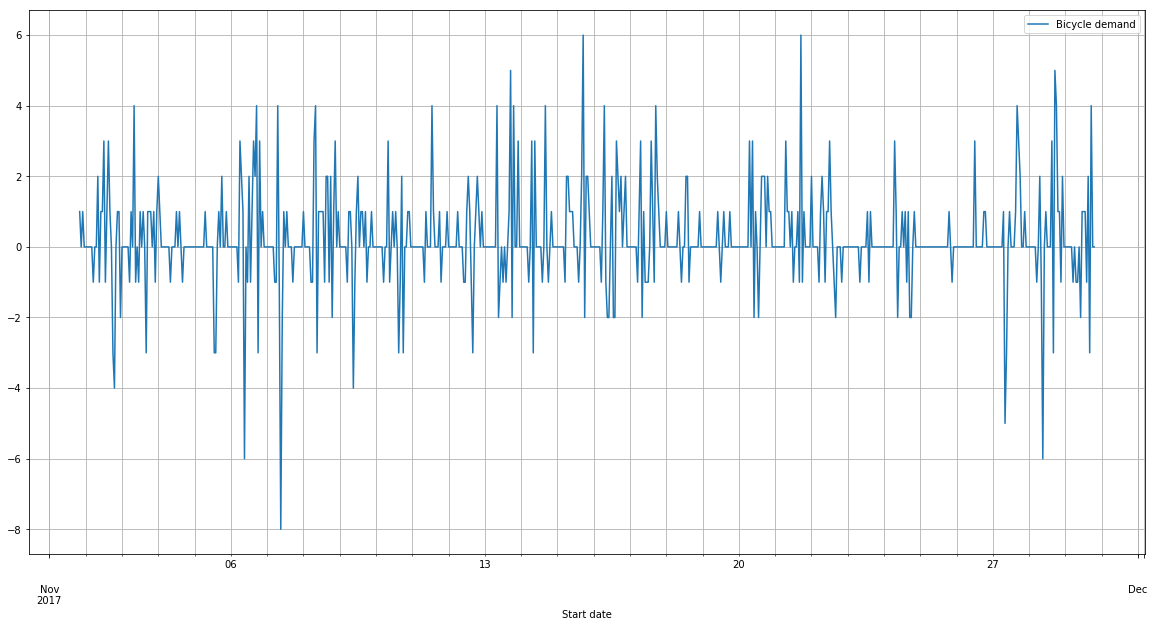

In [44]:
stn7 = pd.DataFrame(np.array(demand_by_hr[7]),columns=["Bicycle demand"])
stn7.index = demand_by_hr.index
stn7[-1444:-772].plot(figsize=(20,10))
plt.grid(True,which="both")
plt.show()

# The number of hours in a week is 168, meaning in 4 weeks we have 672. Effectively what we're plotting here is the bicycle
# use at Station 7 during November, 2017.

Not completely illuminating, but I think we can pick out 5-day clumps representing the weekdays. Let's try finding some averages; that should help to cancel out any noise.

In [45]:
# The following finds the weekly average, i.e., it averages all the Mondays, all the Tuesdays,..., and then presents it in a
# dataframe of 7 days.

# We initialise the dataframe of running totals.
stn7_summed_by_week = pd.DataFrame(np.zeros([168,1]),columns=["Bicycle demand"])
# A neat trick to convert a DatetimeIndex to a TimedeltaIndex is to subtract a "start date"; we define the latter here.
start = stn7.index.min()
# Then we apply our trick, initialising the index of our running total dataframe.
stn7_summed_by_week.index = stn7.index[:168]-start
for j in range(num_years * 52): # (there are 52 weeks in a year)
    # We take the current week in our iteration...
    current_week = stn7.iloc[j*168:(j+1)*168]
    # ...give it the right index...
    current_week.index = stn7_summed_by_week.index
    # ...and then add it to the running total.
    stn7_summed_by_week["Bicycle demand"] = stn7_summed_by_week["Bicycle demand"].add(current_week["Bicycle demand"].astype("float64"))
# In this way we catch almost all the days of the 5-year period, except the final 0.7 of a week, i.e., about 4 days.

# To find the means we divide by the total number of weeks.
stn7_mean_week = stn7_summed_by_week / (num_years * 52)
# For precision we rename the column.
stn7_mean_week.columns = ["Mean demand for bikes"]

# Finally, since 2013 began on a Tuesday, we cyclically shift our dataframe by 24 hours (note 144 = 168 - 24), to give a nicer
# representation of the data when we plot it shortly.
stn7_mean_week = pd.concat([stn7_mean_week.iloc[144:],stn7_mean_week.iloc[:144]])
stn7_mean_week.index = stn7_summed_by_week.index

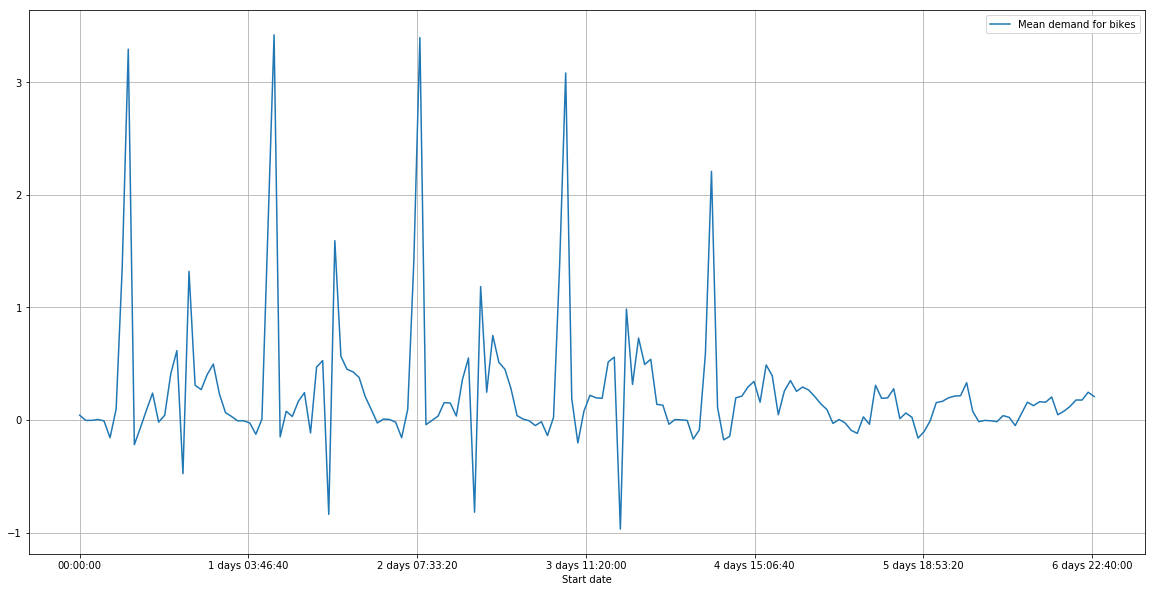

In [46]:
# Let's plot!
stn7_mean_week.plot(figsize=(20,10))
plt.grid(True, which="both")
plt.show()

Very interesting. We can see quite clearly the weekdays and weekend, the former showing up as highly oscillatory and seemingly quite predictable, and the latter appearing mostly as very low amplitude noise. Our `demand_by_hr` looks ripe for doing some Fourier analysis. 

### 3.2 Fourier transform

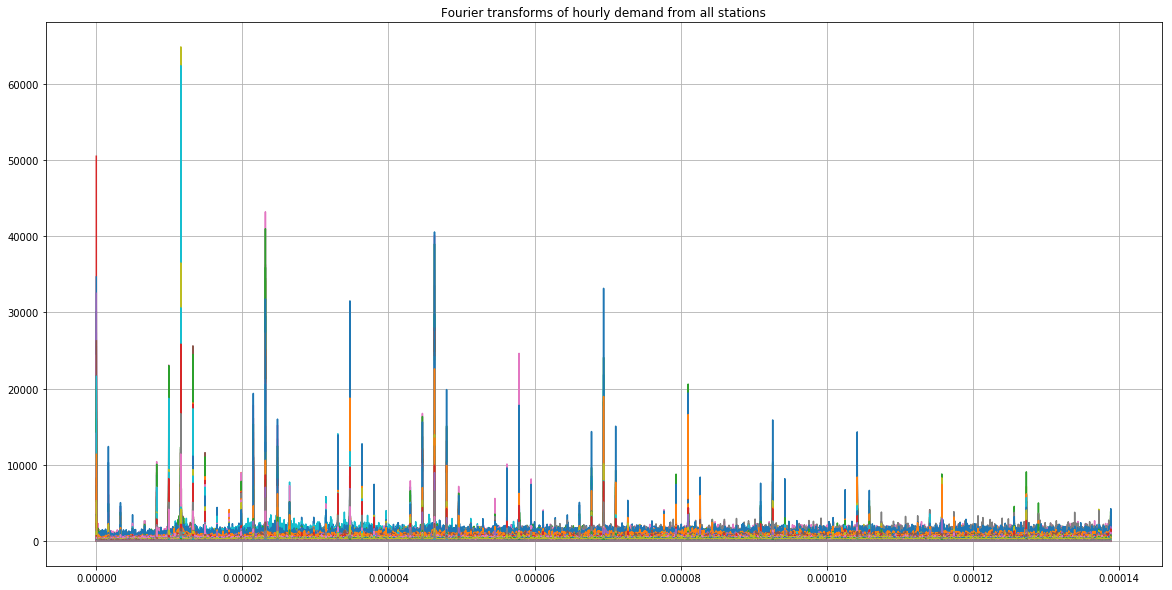

In [137]:
import numpy.fft as npf

N = demand_by_hr.shape[0]
T = 3600 # seconds in an hour
scale = 1
F_demand = npf.fft(np.array(demand_by_hr),axis=0)
Xf = np.linspace(0,1/(2*scale*T),N//(2*scale))

plt.figure(figsize=(20,10))
plt.title("Fourier transforms of hourly demand from all stations")
plt.plot(Xf,np.abs(F_demand[:N//(2*scale),:]))
plt.grid()
plt.show()

Look! Colours! Sorry, I got distracted. ;)

We can see immediately a highly structured Fourier transform, suggesting our data can be well approximated by a Fourier series. The different stations (represented automatically in different colours by Python) have different heights of local maxima, but these maxima are *all* located at the same points, indicating that the oscillations are all taking place at the same frequencies, as we would expect from an intuitive consideration of the daily/weekly/yearly demand for bikes.

### 3.3 Fourier series approximation

To form our predictive model we need to choose the frequencies represented by the peaks in the Fourier transform plot and assign to them the intensities given by the height of these peaks...for *each* station. To do this we'll find the positions of the relative maxima and choose those that are greater than some threshold, so that we can cut out the noise. Later we can do validation on the data from 2018, to choose the best cut-off for each station.

To find these peaks we can define some functions to help us.

In [48]:
# We'll use scipy's signal processing function, find_peaks, which finds the positions of local maxima in 1-dim numpy arrays.
from scipy.signal import find_peaks

# However find_peaks doesn't see peaks at end-points, so we make a small adjustment to it.
def find_peaks_ends (x, height):
    '''INPUTS:
    x and height from find_peaks (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)
    OUTPUTS:
    same as find_peaks (positions of local maxima in x), except also finds the end-points if they are local maxima'''
    
    shift = 0
    if (x[0] >= x[1]) & (x[-1] >= x[-2]):
        y = np.append(np.insert(x, 0, x[0]-1), x[-1]-1)
        shift = 1
    elif x[0] >= x[1]:
        y = np.insert(x, 0, x[0]-1)
        shift = 1
    elif x[-1] >= x[-2]:
        y = np.append(x, x[-1]-1)
    else:
        y = x
        
    return find_peaks(y, height)[0] - shift
    # We take the 0th component of the output to remove the "height" information automatically supplied by find_peaks.

In [49]:
# Our second function takes find_peaks_ends and applies it to a specified axis of a 2-dimensional numpy array.
def max_ovr_thresh2 (thresh,array,ax):
    '''INPUTS:
    thresh = a non-negative number, or a 1-dimensional numpy array of non-negative numbers (length must equal the non-ax 
             dimension of array!)
    array = a (non-empty) 2-dimensional numpy array
    ax = the axis on which to find the maxima, i.e., 0 (maxima along each column) or 1 (maxima along each row)
    
    OUTPUTS:
    a dictionary of length the OTHER axis of array, i.e., 1 or 0 correspondingly,
    whose entries are 1-dim numpy arrays of the local maxima along columns (ax=0)
    or rows (ax=1) that also exceed thresh'''
    
    if ax == 1:
        array = np.transpose(array)
    
    sz = np.size(array,axis=1)
    if not np.shape(thresh): # checks if thresh is a scalar
        thresh = [thresh for j in range(sz)] # then fills an array with the scalar value
    elif len(thresh) != sz: # otherwise checks if the vector thresh has an appropriate size
        raise ValueError("size of threshold ({}) does not match size of desired axis of array ({})".format(thresh.size,sz))
    
    indices = {j : [] for j in range(sz)}
    for j in range(np.size(array,axis=1)):
        indices[j] = find_peaks_ends(x = array[:,j], height = thresh[j])
    
    return indices

Now we've got our functions, let's apply them to our Fourier transforms to isolate the dominant peaks, and then use these to form our Fourier series. However correctly isolating the peaks from the noise is not trivial, especially when we observe from the figure of Fourier transforms that the noises at different stations take place on different scales (the blue is noisiest, the orange, red and olive-green have progressively less noise). It's for this reason that we built in a vector functionality into `max_ovr_thresh2`: it allows us to specify different thresholds of noise for the different stations. Moreover we can then cross-validate our Fourier series model against the data from 2018, choosing a threshold for each station that minimises the error.

In fact, we'll cross-validate against the data from the first two quarters of 2018, and then produce a final metric of performance from the remaining data of 2018.

### 3.4 Choosing the peaks

To begin with we'll run with a single station, number 7, just to get a feel for how our Fourier series looks.

In [131]:
from sklearn.metrics import mean_squared_error

In [167]:
thr = 0 # I'm simply eyeballing a value from the FT figure that should capture most peaks and omit most noise
val = 0.00005

F_array_abs = np.abs(F_demand)
indices = max_ovr_thresh2(thr, F_array_abs, 0)
#indices = indices[0][stn7farr[indices[0]] > thresh]
# print(Xf.shape,N//2)
# print(indices[7])
# print(Xf[indices[7][:len(indices[7])//2]])

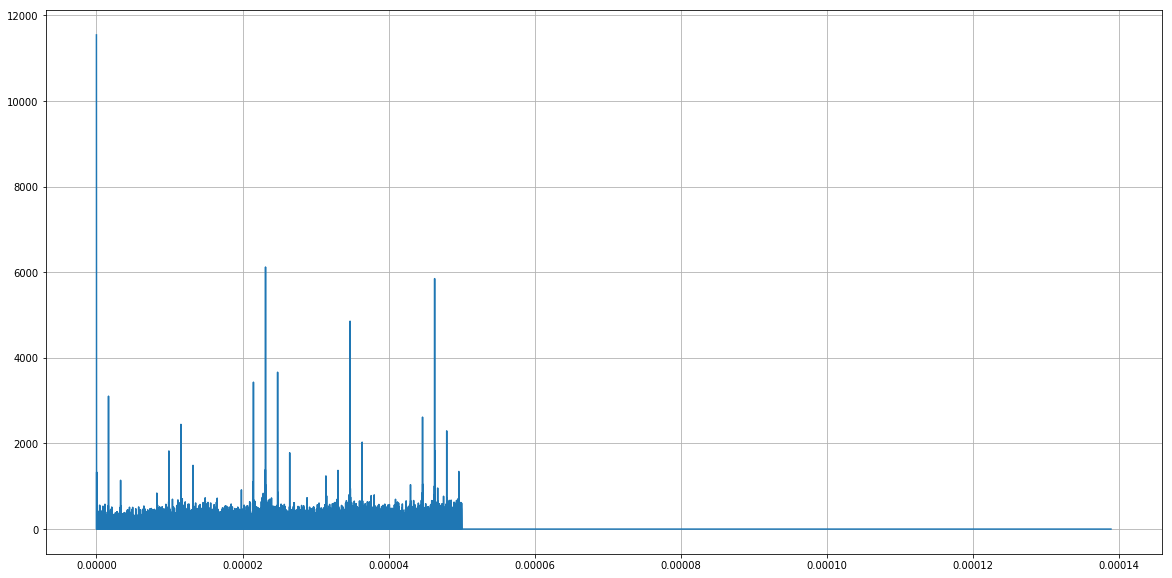

In [190]:
reconst_stn7_F = np.zeros(np.size(F_array_abs,axis=0),dtype=complex)
#reconst_ft[0]=stn7f[0]
for j in indices[7]:
    if np.concatenate((Xf,Xf[-1]-Xf[0]+Xf),axis=0)[j] < val or np.concatenate((Xf,Xf[-1]-Xf[0]+Xf),axis=0)[j] > 2*Xf[-1]-Xf[0]-val:
        reconst_stn7_F[j] = F_demand[j,7]
plt.figure(figsize=(20,10))
plt.plot(Xf,np.abs(reconst_stn7_F[:N//(2)]))
plt.grid()
plt.show()

In [191]:
# print(reconst_stn7_F.shape)
reconst_stn7_arr = npf.ifft(reconst_stn7_F)
# print(reconst_stn7_arr.shape)
reconst_stn7 = pd.DataFrame(np.real(reconst_stn7_arr),columns=['Prediction'])
reconst_stn7.index = stn7.index
# reconst_stn7_F.shape

In [192]:
print(mean_squared_error(reconst_stn7,stn7))

1.9536615238426376


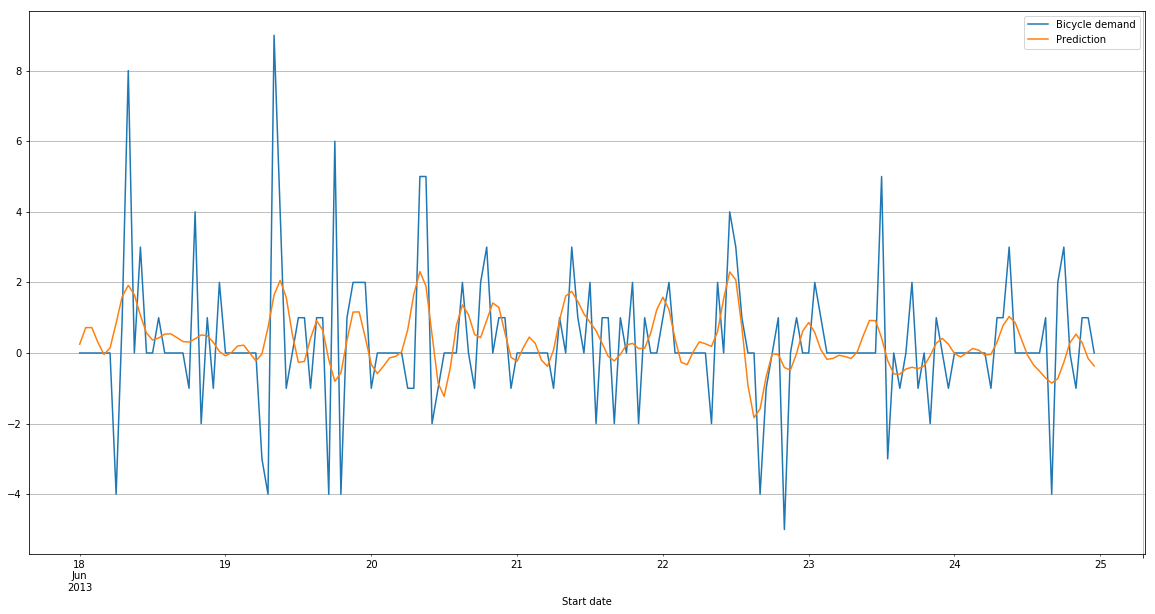

In [185]:
start_hr = 1344*3
ran = list(range(start_hr,start_hr+168))
ax = stn7.iloc[ran].plot(figsize=(20,10))
reconst_stn7.iloc[ran].plot(ax=ax,figsize=(20,10))
plt.grid()
plt.show()

In [ ]:
thresholds = [100*j for j in range(20)]
training_errors = [mean_squared_error]

In [193]:
import datetime

In [196]:
def find_weekday(x):
    fmt = "%Y-%m-%d %H:%M:%S"
    day = datetime.datetime.strptime(x,fmt).weekday()
    if day<5:
        return 1 
    else:
        return 0 

In [206]:
demand_by_hr.head()

,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 01:00:00,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 02:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
demand_by_hr['Day of the week']=demand_by_hr.index.weekday

In [216]:
demand_by_hr['Working day'] = demand_by_hr['Day of the week'].apply(lambda x: 1 if x<5 else 0)

In [221]:
demand_by_hr['Hour and date'] = demand_by_hr.index

In [223]:
demand_by_hr_workdays = demand_by_hr.loc[demand_by_hr['Working day'] == 1]
demand_by_hr_weekends = demand_by_hr.loc[demand_by_hr['Working day'] == 0]

In [226]:
demand_by_hr_workdays.drop('Day of the week',axis=1,inplace=True).drop('Working day',axis=1,inplace=True)

KeyError: "labels ['Day of the week'] not contained in axis"

In [244]:
demand_by_hr_workdays.set_index(pd.timedelta_range('0 days 0 hours 0 minutes', periods=len(demand_by_hr_workdays), freq='H'),inplace=True)

Plan
1. Use single fixed threshold to compute Fourier series approximations.
2. Use the FS approximations to make a model that, given YYYY-MM-DD HH:00:00, predicts the bike demand for the following hour.

    2a. This means we need to know on what day-of-the-week each year starts.

    2b. Then we convert the DatetimeIndex into a TimedeltaIndex.
3. Compute the cross-validation L^2 error for each station, from 2018 Q1-Q2.
4. Use this CV error to define the output of a CV cost function (inputs: threshold vector, FT (fixed!)).
5. Use a for-loop and 1-dimensional gradient descent to minimise the CV cost function.
6. Use the minimising thresholds to form the final predictive model and test its prediction on 2018 Q3-Q4.

Ciro's list of things to do:
1. Average demand by day of the week, i.e., average demand on Monday, ...
2. Split into weekdays and weekends, and somehow compare?
3. Want to cluster stations by whether they're outgoing or incoming at certain times of the day

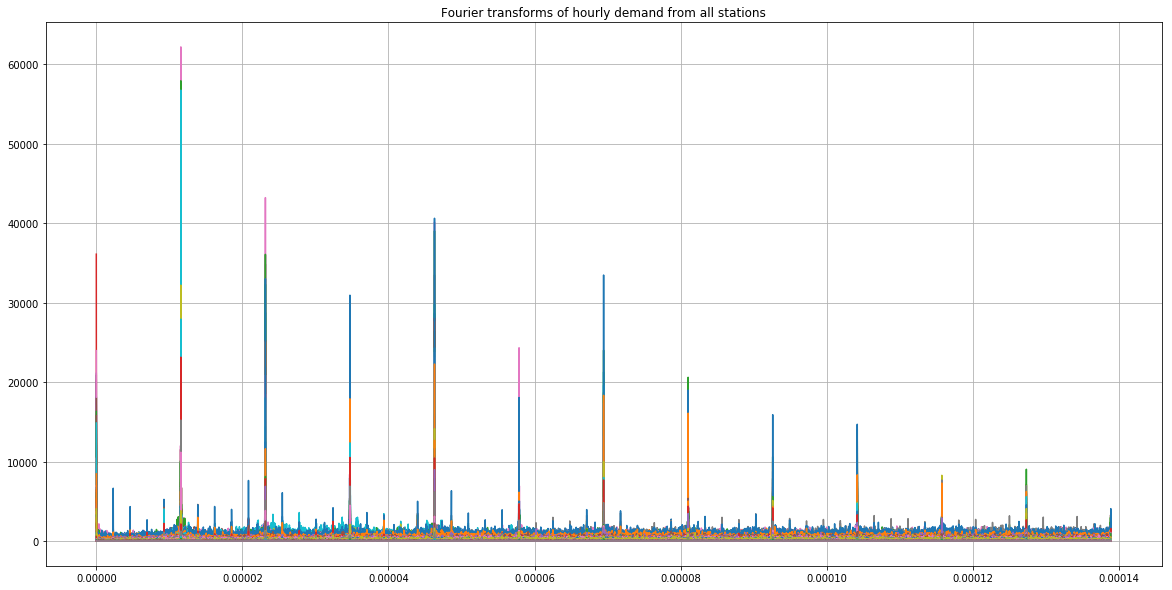

In [245]:
import numpy.fft as npf

N = demand_by_hr_workdays.shape[0]
T = 3600 # seconds in an hour
scale = 1
F_demand_workdays = npf.fft(np.array(demand_by_hr_workdays.drop('Hour and date',axis=1)),axis=0)
Xf = np.linspace(0,1/(2*scale*T),N//(2*scale))

plt.figure(figsize=(20,10))
plt.title("Fourier transforms of hourly demand from all stations")
plt.plot(Xf,np.abs(F_demand_workdays[:N//(2*scale),:]))
plt.grid()
plt.show()

In [304]:
1/(4*3600)

6.944444444444444e-05

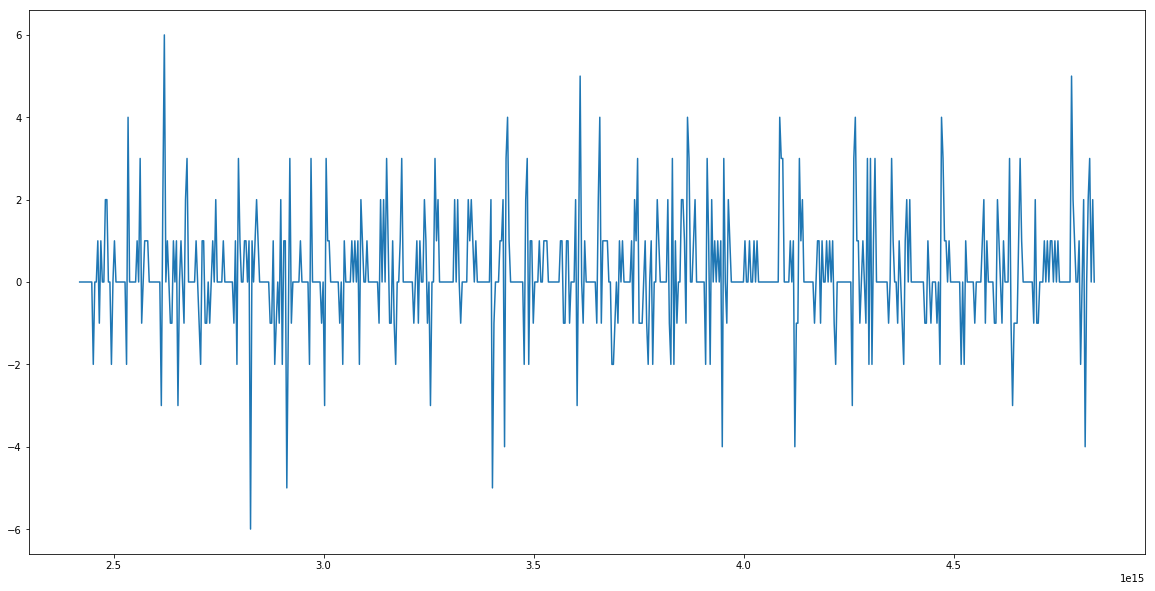

In [247]:
plt.figure(figsize=(20,10))
plt.plot(demand_by_hr_workdays[7][672:1344])
plt.show()

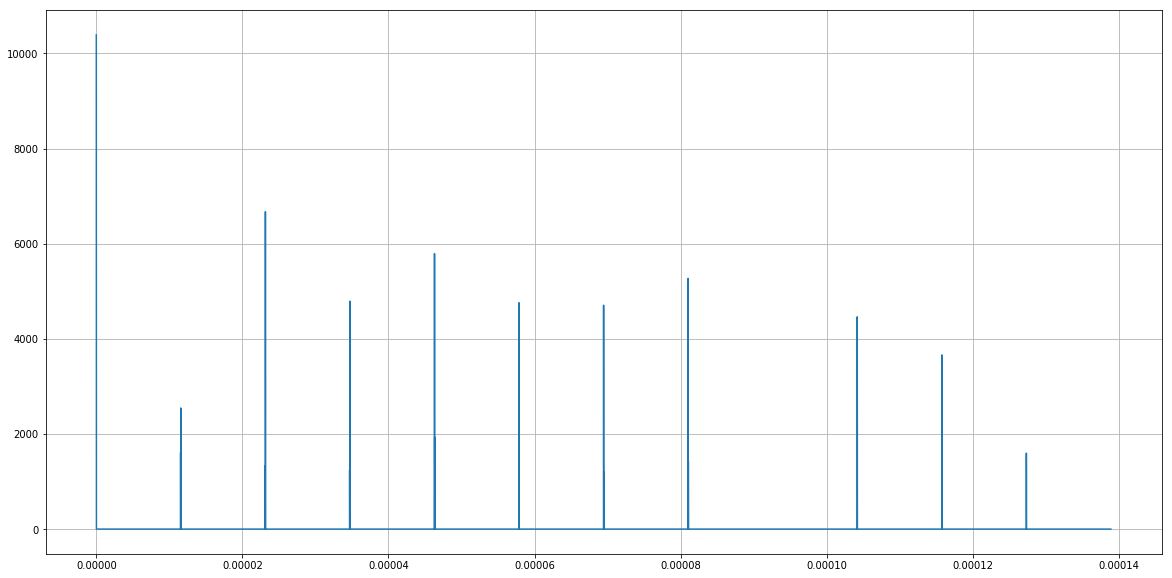

In [267]:
thr = 1200 # I'm simply eyeballing a value from the FT figure that should capture most peaks and omit most noise
val = 0.00014

F_workdays_array_abs = np.abs(F_demand_workdays)
indices_workdays = max_ovr_thresh2(thr, F_workdays_array_abs, 0)
reconst_stn7_workdays_F = np.zeros(np.size(F_workdays_array_abs,axis=0),dtype=complex)
#reconst_ft[0]=stn7f[0]
for j in indices_workdays[7]:
#     if np.concatenate((Xf,Xf[-1]-Xf[0]+Xf),axis=0)[j] < val or np.concatenate((Xf,Xf[-1]-Xf[0]+Xf),axis=0)[j] > 2*Xf[-1]-Xf[0]-val:
    reconst_stn7_workdays_F[j] = F_demand_workdays[j,7]
plt.figure(figsize=(20,10))
plt.plot(Xf,np.abs(reconst_stn7_workdays_F[:N//(2)]))
plt.grid()
plt.show()

In [268]:
reconst_stn7_workdays_arr = npf.ifft(reconst_stn7_workdays_F)
# print(reconst_stn7_arr.shape)
reconst_stn7_workdays = pd.DataFrame(np.real(reconst_stn7_workdays_arr),columns=['Prediction'])
reconst_stn7_workdays.index = demand_by_hr_workdays.index
# reconst_stn7_F.shape

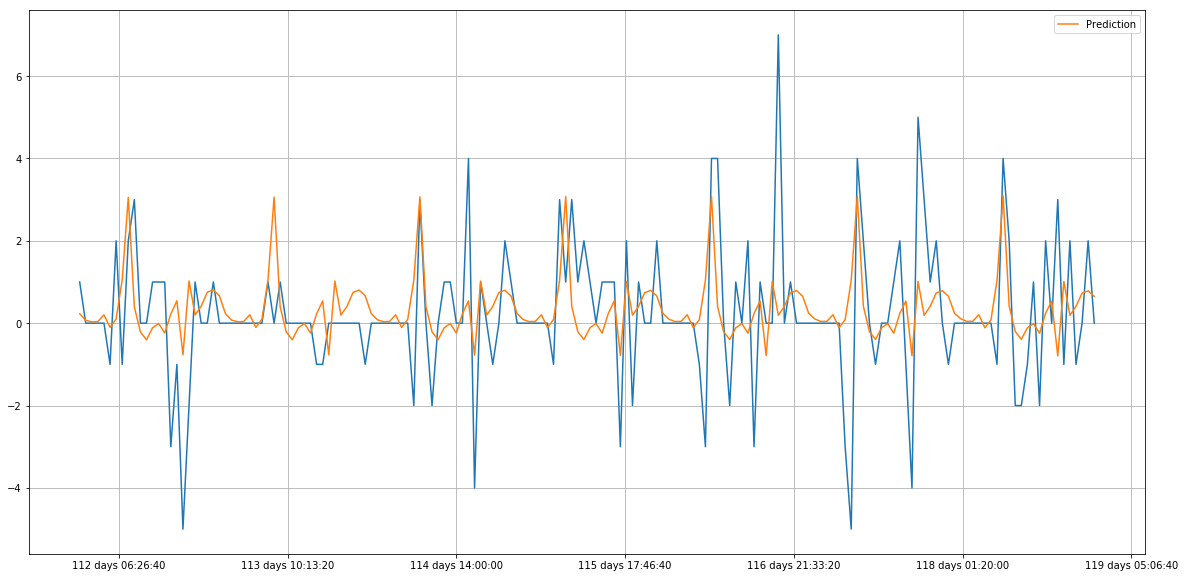

In [269]:
start_hr = 1344*2
ran = list(range(start_hr,start_hr+168))
ax = demand_by_hr_workdays[7].iloc[ran].plot(figsize=(20,10))
reconst_stn7_workdays.iloc[ran].plot(ax=ax,figsize=(20,10))
plt.grid()
plt.show()